## A NMC/Gr parameterisation example using PyBOP

This notebook introduces a synthetic re-parameterisation of the single-particle model with corrupted observations. To start, we import the PyBOP package for parameterisation and the PyBaMM package to generate the initial synethic data,

In [1]:
%pip install --upgrade pip ipywidgets pybamm -q
%pip install git+https://github.com/pybop-team/PyBOP.git@develop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Next, we import the added packages plus any additional dependencies,

In [2]:
import pybop
import pybamm
import matplotlib.pyplot as plt
import numpy as np

## Generate Synthetic Data

We need to generate the synthetic data required for later reparameterisation. To do this we will run the PyBaMM forward model and store the generated data. This will be integrated into PyBOP in a future release for fast synthetic generation. For now, we define the PyBaMM model with a default parameter set,

In [3]:
synthetic_model = pybamm.lithium_ion.SPM()
params = synthetic_model.default_parameter_values

We can now modify individual parameters with the bespoke values and run the simulation.

In [4]:
params.update(
    {
        "Negative electrode active material volume fraction": 0.52,
        "Positive electrode active material volume fraction": 0.63,
    }
)

Define the experiment and run the forward model to capture the synthetic data.

In [5]:
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1C for 15 minutes (1 second period)",
            "Rest for 2 minutes (1 second period)",
            "Charge at 1C for 15 minutes (1 second period)",
            "Rest for 2 minutes (1 second period)",
        ),
    ]
    * 2
)
sim = pybamm.Simulation(synthetic_model, experiment=experiment, parameter_values=params)
synthetic_sol = sim.solve()

Plot the synthetic data,

In [6]:
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.1333333333333333, step=0.01133333333333333…

Now, let's corrupt the synthetic data with 5mV of gaussian noise centered around zero,

In [7]:
corrupt_V = synthetic_sol["Terminal voltage [V]"].data
corrupt_V += np.random.normal(0, 0.001, len(corrupt_V))

## Identify the Parameters

Now, to blind fit the synthetic parameters we need to define the observation variables as well as update the forward model to be of PyBOP type (This composes PyBaMM's model class). For the observed voltage variable, we used the newly corrupted voltage array, 

In [8]:
model = pybop.lithium_ion.SPM()
dataset = [
    pybop.Dataset("Time [s]", synthetic_sol["Time [s]"].data),
    pybop.Dataset("Current function [A]", synthetic_sol["Current [A]"].data),
    pybop.Dataset("Voltage [V]", corrupt_V),
]

Next, we define the targeted forward model parameters for estimation. Furthermore, PyBOP provides functionality to define a prior for the parameters. The initial parameters values used in the estimiation will be randomly drawn from the prior distribution.

In [9]:
parameters = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.5, 0.02),
        bounds=[0.375, 0.625],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.65, 0.02),
        bounds=[0.525, 0.75],
    ),
]

We can now construct a cost function and define the fitting signal.

In [10]:
# Define the cost to optimise
cost = pybop.RMSE()
signal = "Voltage [V]"

Let's construct PyBOP's optimisation class. This class provides the methods needed to fit the forward model.

In [11]:
parameterisation = pybop.Optimisation(
    cost=cost,
    model=model,
    optimiser=pybop.NLoptOptimize(n_param=len(parameters)),
    parameters=parameters,
    dataset=dataset,
    signal=signal,
)

Finally, we run the estimation algorithm. For this example, we use a root-mean square cost function with the BOBYQA algorithm implemented in NLOpt

In [12]:
x, output, final_cost, num_evals = parameterisation.run()

Cost: 0.0014306419900053451
Cost: 0.001878140952546479
Cost: 0.0056853760898525705
Cost: 0.0011144296137402825
Cost: 0.004234408585704868
Cost: 0.002260880733148505
Cost: 0.0010374243859739255
Cost: 0.0011340799888696297
Cost: 0.001093836134793644
Cost: 0.001042723321241934
Cost: 0.0010266172137603305
Cost: 0.00103588203364289
Cost: 0.001007039288536067
Cost: 0.000990040153496016
Cost: 0.0009820913602296417
Cost: 0.0009795434928262323
Cost: 0.0009945581830178092
Cost: 0.0009921144772808324
Cost: 0.0009825846380214938
Cost: 0.0009915338481534652
Cost: 0.0009789337894256292
Cost: 0.0009823901578605396
Cost: 0.0009786983892344486
Cost: 0.0009785339841692688
Cost: 0.000978719434079295
Cost: 0.000978406378769787
Cost: 0.0009784181875287846
Cost: 0.0009792572769492622
Cost: 0.0009789609220288331
Cost: 0.000979061722139482
Cost: 0.0009784215735618952
Cost: 0.0009790240608910446
Cost: 0.0009784386249667666
Cost: 0.0009784283248914902
Cost: 0.0009784142223954373
Cost: 0.0009791106518699038
Cost

Let's view the identified parameters:

In [13]:
x

array([0.50138974, 0.63221165])

## Plotting

First, run SPM forward model with the estimated parameters,

In [14]:
params.update(
    {
        "Negative electrode active material volume fraction": x[0],
        "Positive electrode active material volume fraction": x[1],
    }
)
optsol = sim.solve()["Terminal voltage [V]"].data

Now, we plot the estimated forward model against the corrupted synthetic observation,

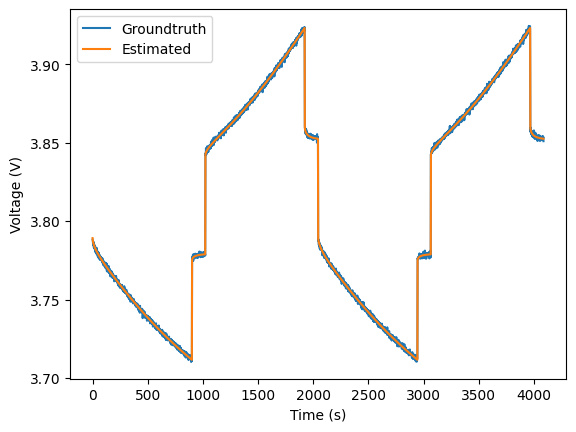

In [15]:
plt.plot(corrupt_V, label="Groundtruth")
plt.plot(optsol, label="Estimated")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()